In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import os

gpus=tf.config.experimental.list_physical_devices('GPU')
#prevent oom errors
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

data='cnt'
extensions=['jpeg','jpg','bmp','png']
classes=['happy', 'sad']
# Iterate through class directories and validate images
for img_class in os.listdir(data):
  if img_class in classes:
    class_dir=os.path.join(data,img_class,)
    for img_file in os.listdir(class_dir):
      img_path=os.path.join(class_dir,img_file)
      try:
        img=cv2.imread(img_path)
        ext=imghdr.what(img_path)
        if ext not in extensions:
          print('image not found in extension list sorry {}'.format(img_path))
          os.remove(img_path)
      except Exception as e:
        print('image has an issue {}'.format(img_path))





In [6]:
# Processing step in the image classification pipeline
dt=tf.keras.utils.image_dataset_from_directory(data)
# Convert dataset to an iterator and retrieve a batch
dt_iterator= dt.as_numpy_iterator()
batch=dt_iterator.next()
#normalize image pixel values
scaled=batch[0]/255
# check the maximum pixel value after normalization
scaled.max()

Found 172 files belonging to 2 classes.


1.0

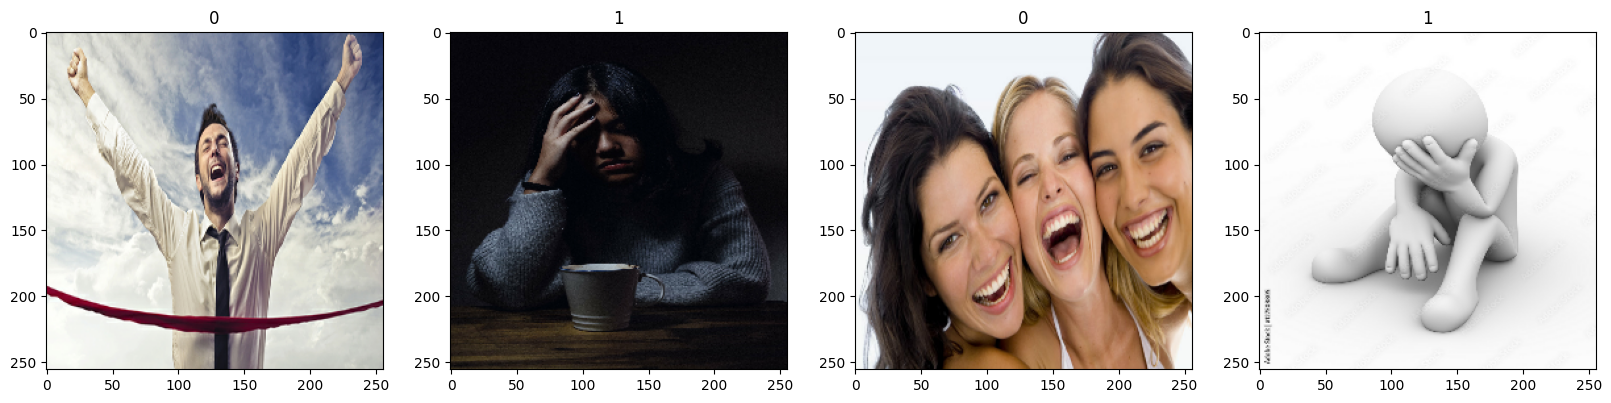

In [7]:
# Visualize images and results using plotting libraries
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

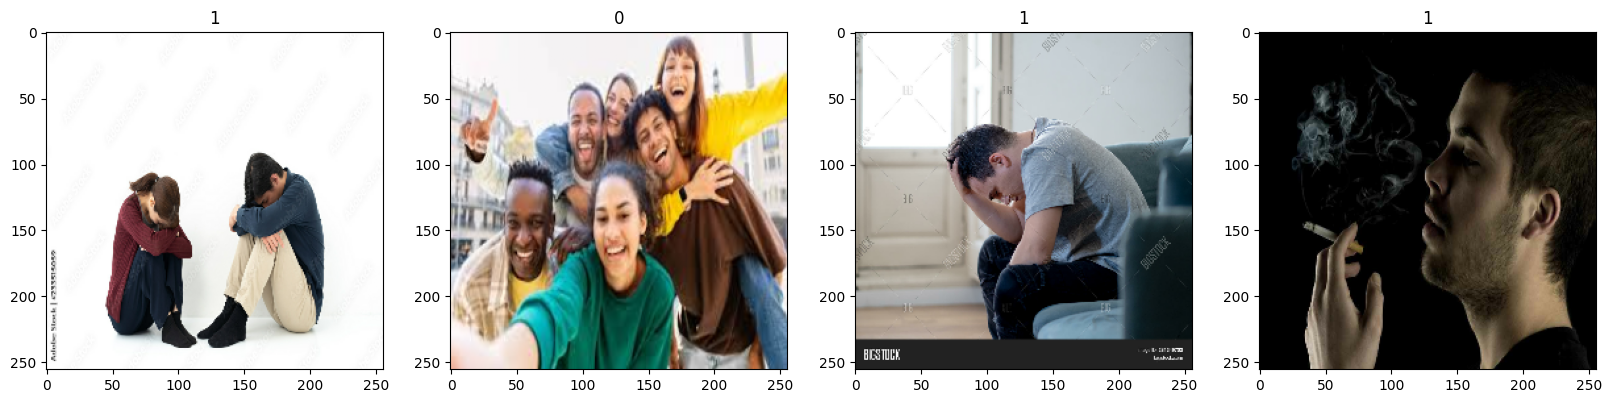

In [8]:
# Normalize image pixel values
dt=dt.map(lambda x,y:(x/255,y))

# Convert dataset to an iterator and retrieve a batch
sc_iterator=dt.as_numpy_iterator()
batch=sc_iterator.next()

# visualize first 4 images with their labels
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [9]:
# Split the dataset into training, validation, and test sets
train_size=int(len(dt)*.7)
val_size=int(len(dt)*.2)
test_size=len(dt) - train_size - val_size

# Create dataset partitions
train=dt.take(train_size)
val=dt.skip(train_size).take(val_size)
test=dt.skip(train_size+val_size).take(test_size)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Define a sequential convolutional neural network model
model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(16, (3, 3), strides=1, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), strides=1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), strides=1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [11]:
# Set up directory for logging TensorBoard data
logdir='logs'

# Create a TensorBoard callback to monitor training progress
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model for 50 epochs using the training set, validate on the validation set,
# and log the training process for visualization in TensorBoard
hist=model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
4/4 [==============================] - 2s 348ms/step - loss: 1.5145 - accuracy: 0.5703 - val_loss: 1.3644 - val_accuracy: 0.3125
Epoch 2/50
4/4 [==============================] - 2s 319ms/step - loss: 0.7640 - accuracy: 0.5859 - val_loss: 0.5451 - val_accuracy: 0.6875
Epoch 3/50
4/4 [==============================] - 2s 319ms/step - loss: 0.5864 - accuracy: 0.7109 - val_loss: 0.5595 - val_accuracy: 0.7500
Epoch 4/50
4/4 [==============================] - 2s 337ms/step - loss: 0.5399 - accuracy: 0.6875 - val_loss: 0.4218 - val_accuracy: 0.7500
Epoch 5/50
4/4 [==============================] - 2s 321ms/step - loss: 0.4385 - accuracy: 0.8125 - val_loss: 0.5212 - val_accuracy: 0.7812
Epoch 6/50
4/4 [==============================] - 2s 319ms/step - loss: 0.4639 - accuracy: 0.7500 - val_loss: 0.3602 - val_accuracy: 0.8438
Epoch 7/50
4/4 [==============================] - 2s 315ms/step - loss: 0.3822 - accuracy: 0.8906 - val_loss: 0.4322 - val_accuracy: 0.9062
Epoch 8/50
4/4 [====

In [21]:
# Retrieve the training history of the model
# This includes loss and accuracy values for both training and validation sets
hist.history


Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


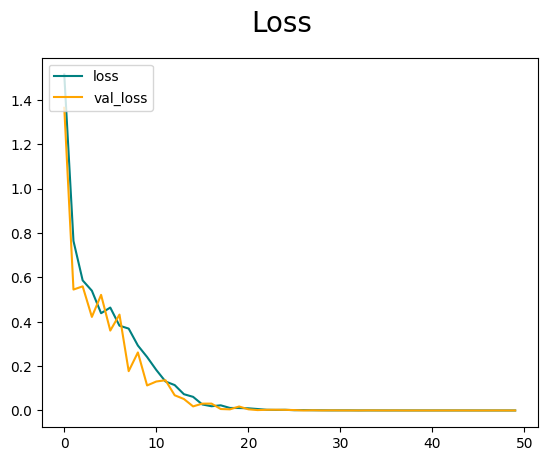

In [13]:
# Plot training and validation loss
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

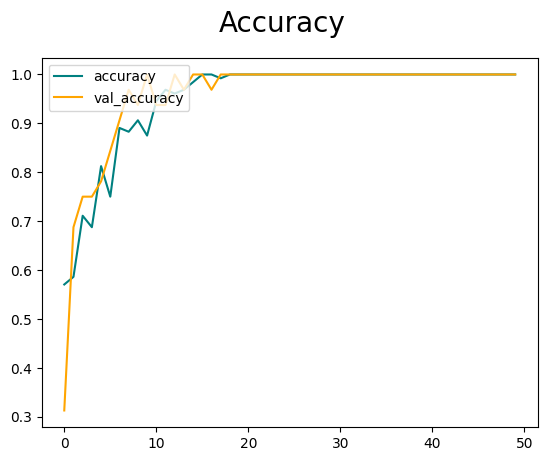

In [14]:
# Plot training and validation accuracy
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# Initialize evaluation metrics
precision=Precision()
recall=Recall()
accuracy=BinaryAccuracy()

# Iterate through the test dataset and update metrics for each batch
for batch in test.as_numpy_iterator():
  X,y=batch
  yhat=model.predict(X)
  precision.update_state(y,yhat)
  recall.update_state(y,yhat)
  accuracy.update_state(y,yhat)
  
  
# Print the final computed metrics
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

1/1 [==============================] - 0s 62ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


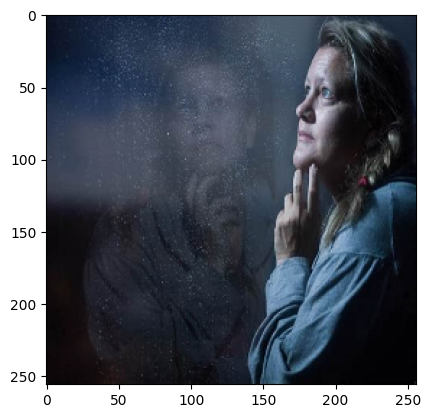

In [16]:
import cv2
# Read the test image using OpenCV
img=cv2.imread('test_files\sda.jpeg')

# Convert the image from BGR to RGB and resize it
resize=tf.image.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),(256,256))

# Display the resized image
plt.imshow(resize.numpy().astype(int))
plt.show()


In [17]:
#testing phase
# Make a prediction on the resized image
yhat=model.predict(np.expand_dims(resize/255,0))
print(yhat)

# Determine and print the predicted class based on the threshold
if yhat>0.5:
  print(f'Predicted class is sad')
else:
  print(f'Predicted class is happy')

1/1 [==============================] - 0s 13ms/step
[[0.9999528]]
Predicted class is sad


In [24]:
from tensorflow.keras.models import load_model
#save trained model
model.save(os.path.join('models','imageclassifier.h5'))

#load saved model
new_model=load_model(os.path.join('models','imageclassifier.h5'))

In [25]:
yhatnew=new_model.predict(np.expand_dims(resize/255,0))
print(yhatnew)
if yhatnew>0.1:
  print(f'Predicted class is sad')
else:
  print(f'Predicted class is happy')

1/1 [==============================] - 0s 30ms/step
[[0.9999528]]
Predicted class is sad
